In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

def plot_dirichlet(alpha, num_samples=10000):
    """
    Visualize a Dirichlet distribution on a 2D simplex.
    
    Parameters:
    - alpha: Array of concentration parameters for the Dirichlet distribution.
    - num_samples: Number of samples to generate.
    """
    # Generate samples
    samples = dirichlet.rvs(alpha, size=num_samples)

    # Transform to simplex coordinates for 2D plotting
    x = samples[:, 0]
    y = samples[:, 1]

    # Plot the simplex
    plt.figure(figsize=(8, 8))
    plt.hist2d(x, y, bins=100, range=[[0.9,1],[0.0,0.1]])
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f"Dirichlet Visualization (alpha={alpha})")
    plt.grid(True)
    plt.show()

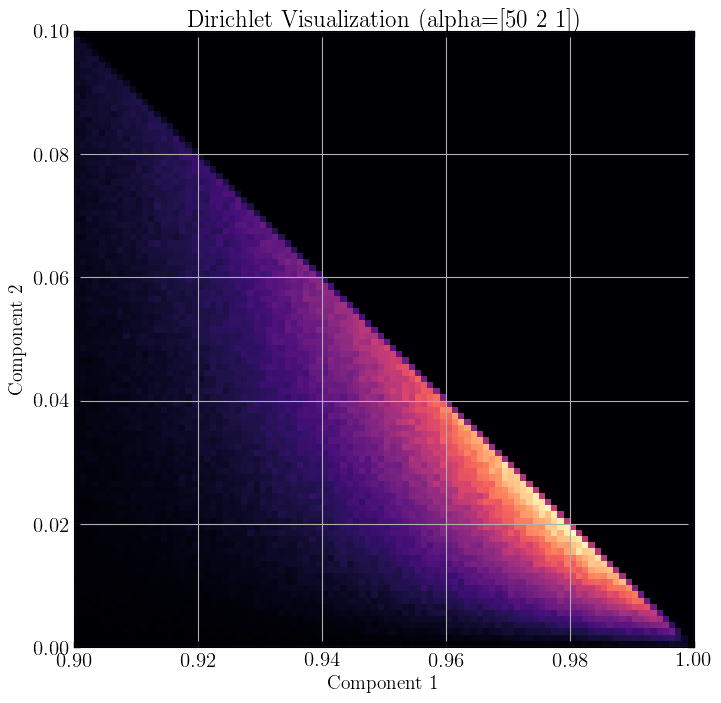

In [22]:
# Example: Visualizing a Dirichlet prior
alpha = 1*jnp.array([50,2,1])  # Symmetric Dirichlet
plot_dirichlet(alpha, 1_000_000)

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cmasher as cmr
cmap=cmr.sunburst_r
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
data = at.Table.read("/Users/Tavangar/Work/CATS_Workshop/cats/data/joined-GD-1.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

# run_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask)]
# bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
# stream_data_ = iso_obj.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask]

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.26720538330726), np.float64(-3.1634227867925135), np.float64(0.5151487185597746), np.float64(0.38624247171130377)] 

Producing the polygon and mask


/Users/Tavangar/Work/stream-membership/stream-env/lib/python3.12/site-packages/cats/CMD.py:293: RuntimeWarning: invalid value encountered in divide
  signal = signal / signal_counts


In [4]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [5]:
print(len(run_data_))
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in run_data_.colnames}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

83735


In [6]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)

In [7]:
bkg_knot_spacings    = jnp.array([40,40,40])
stream_knot_spacings = jnp.array([5,20,20,20])
offtrack_dx          = jnp.array([3,0.75])

bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_pm_mixture=2, 
                                                 coord_bounds=coord_bounds, data=bkg_data)
stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, 
                                                       coord_bounds=coord_bounds, data=stream_data)
offtrack_model, offtrack_phi12_locs = init_stream.make_offtrack_model_component(offtrack_dx, stream_model, 
                                                                                coord_bounds)

mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 1.0])),
    components=[bkg_model, stream_model, offtrack_model],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

In [8]:
specifications = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings, offtrack_dx])

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
MAP_svi_results = full_dict['svi_results']
guide = full_dict['guide']

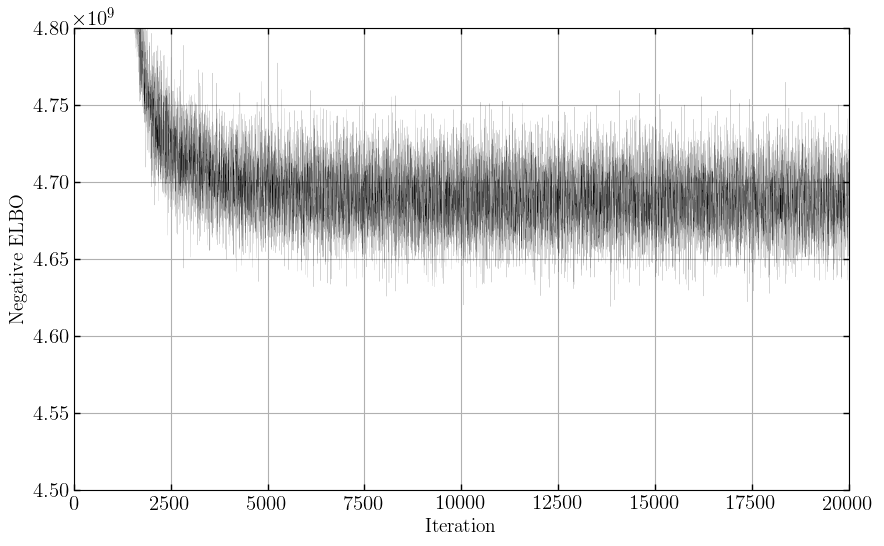

In [9]:
plt.figure(figsize=(10,6))
plt.plot(MAP_svi_results.losses, lw=.06)
plt.xlim(0, 20e3) ; plt.ylim(4.5e9,4.8e9)
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

In [10]:
MAP_p_expanded = get_svi_params(mm, run_data, MAP_svi_results, guide, num_samples=10_000, key=jax.random.PRNGKey(42))

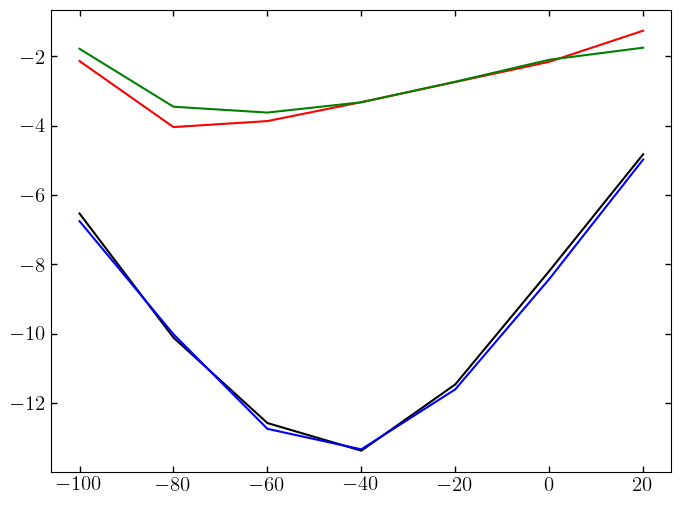

In [11]:
plt.plot(stream_model.coord_parameters['pm1']['knots'], MAP_p_expanded['offtrack']['pm1']['loc_vals'])
plt.plot(stream_model.coord_parameters['pm1']['knots'], MAP_p_expanded['stream']['pm1']['loc_vals'])

plt.plot(stream_model.coord_parameters['pm2']['knots'], MAP_p_expanded['offtrack']['pm2']['loc_vals'])
plt.plot(stream_model.coord_parameters['pm2']['knots'], MAP_p_expanded['stream']['pm2']['loc_vals'])

In [12]:
# MAP_p_expanded['offtrack']['pm1']['scale_vals'] = MAP_p_expanded['stream']['pm1']['scale_vals']
# MAP_p_expanded['offtrack']['pm2']['scale_vals'] = MAP_p_expanded['stream']['pm2']['scale_vals']

In [13]:
print(MAP_p_expanded['offtrack']['pm1']['scale_vals'])
print(MAP_p_expanded['stream']['pm1']['scale_vals'])
print(MAP_p_expanded['mixture-probs'])

[0.40489127 0.48470968 0.39043123 0.21222196 0.33930867 0.47062857
 0.30790648]
[0.41775181 0.24378567 0.18156712 0.12164219 0.13060994 0.22486836
 0.38687408]
[0.97826454 0.01733388 0.00438757]


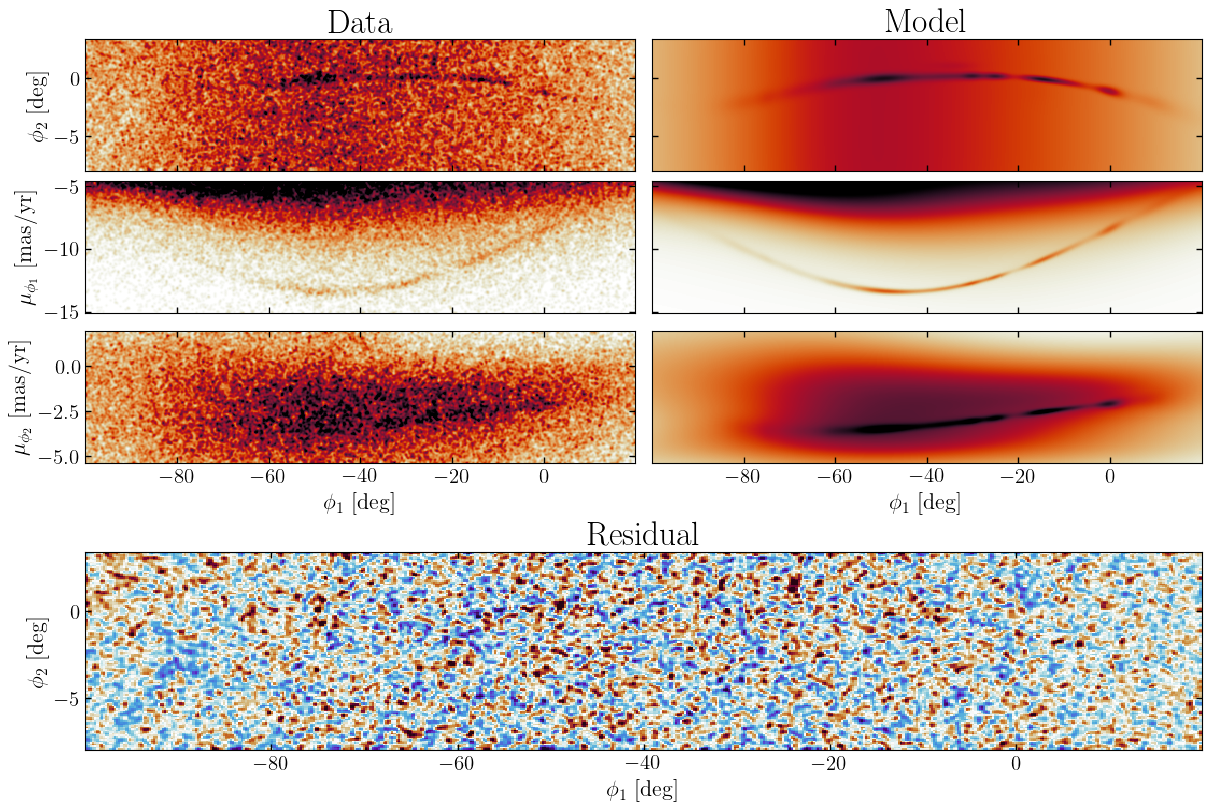

In [14]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)

ax7 = fig.add_subplot(gs[3, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax3, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids,
                          pars=MAP_p_expanded, axes=[ax2,ax4,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=MAP_p_expanded, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=ax7, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1, ax2, ax3, ax4]:
    ax.label_outer()
ax6.yaxis.set_visible(False)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax7.set_title('Residual', fontsize=24, pad=5)

# plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

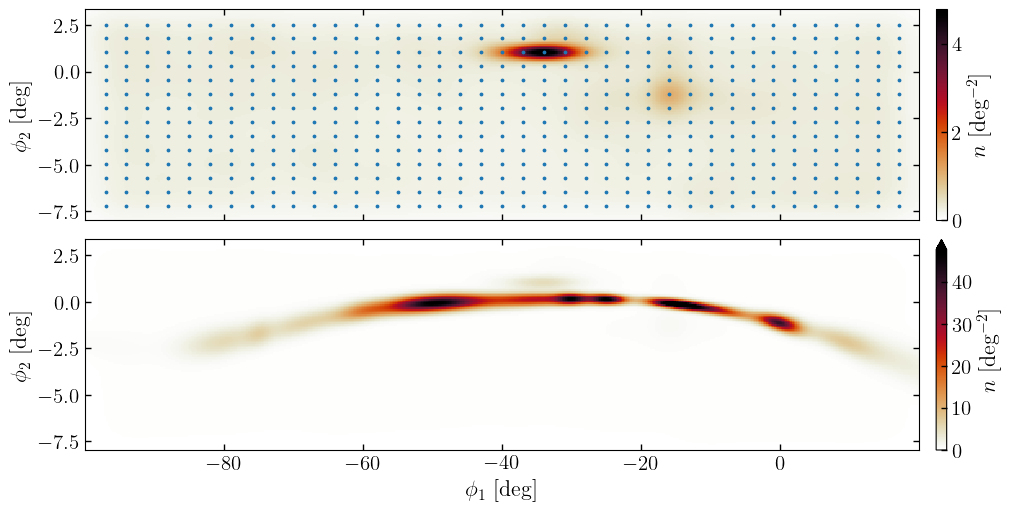

In [19]:
str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[stream_model, offtrack_model],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
    )

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = MAP_p_expanded["mixture-probs"][1:] / jnp.sum(MAP_p_expanded["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

bin_area = jnp.diff(plot_grids['phi1'])[0] * jnp.diff(plot_grids['phi2'])[0]

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_) * MAP_p_expanded["mixture-probs"][2], 
                                                    grids=plot_grids, pars=MAP_p_expanded['offtrack'], grid_coord_names=[('phi1', 'phi2')], axes=ax1,
                                                    pcolormesh_kwargs=dict(rasterized=True, cmap=cmap, vmin=0.0, vmax=0.1))
ax1.scatter(offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=3)
cbar1 = fig.colorbar(pcms1[0], ax=ax1, ticks=jnp.array([0, 2, 4, 6, 8])*bin_area, pad=0.02,
           format=mticker.FixedFormatter(['0', '2', '4', '6', '8']))

_, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_) * jnp.sum(MAP_p_expanded["mixture-probs"][1:]),
                                                pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
cbar2 = fig.colorbar(pcms2[0], ax=ax2, ticks=jnp.array([0, 10, 20, 30, 40, 50])*bin_area, pad=0.02,
           format=mticker.FixedFormatter(['0', '10', '20', '30', '40', '50']), extend='max')




ax1.set_xlabel("")
cbar1.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)


# plt.savefig('../../paper_figures/offtrack_model.pdf')
# plt.savefig('../../paper_figures/offtrack_model.png')
plt.show()

### Make Linear Density Plot

In [20]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = MAP_p_expanded['stream']
offtrack_params = MAP_p_expanded['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [21]:
str_bkg_specs = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings])
no_off_filename = svi_results_dir + 'mm_bkg{}_{}_{}_stream{}_{}_{}_{}.pkl'.format(*str_bkg_specs)

with open(no_off_filename, 'rb') as input_file_:
    no_off_full_dict = pickle.load(input_file_)
    
no_off_MAP_svi_results = no_off_full_dict['svi_results']
no_off_guide = no_off_full_dict['guide']

str_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[bkg_model, stream_model],
)

pred_dist0 = Predictive(no_off_guide, params=no_off_MAP_svi_results.params, num_samples=10_000)
no_off_MAP_p_ = pred_dist0(jax.random.PRNGKey(42), data=run_data)
no_off_MAP_p = {k: jnp.median(v, axis=0) for k, v in no_off_MAP_p_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
MAP_p_no_off_expanded = str_bkg_mm.expand_numpyro_params(no_off_MAP_p)

In [22]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
ndata = len(run_data_)
stream_lin_dens = ndata*MAP_p_expanded['mixture-probs'][1] * jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * (phi1s[1]-phi1s[0])
off_lin_dens = ndata*MAP_p_expanded['mixture-probs'][2] * jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * (phi1s[1]-phi1s[0])


phi2_track = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['scale_vals'])
pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['loc_vals'])
pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['scale_vals'])
pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['scale_vals'])


phi2_track_no_off = IUS(stream_opt.coord_parameters['phi2']['knots'], MAP_p_no_off_expanded['stream']['phi2']['loc_vals'])
phi2_width_no_off = IUS(stream_opt.coord_parameters['phi2']['knots'], MAP_p_no_off_expanded['stream']['phi2']['scale_vals'])
pm1_track_no_off = IUS(stream_opt.coord_parameters['pm1']['knots'], MAP_p_no_off_expanded['stream']['pm1']['loc_vals'])
pm1_width_no_off = IUS(stream_opt.coord_parameters['pm1']['knots'], MAP_p_no_off_expanded['stream']['pm1']['scale_vals'])
pm2_track_no_off = IUS(stream_opt.coord_parameters['pm2']['knots'], MAP_p_no_off_expanded['stream']['pm2']['loc_vals'])
pm2_width_no_off = IUS(stream_opt.coord_parameters['pm2']['knots'], MAP_p_no_off_expanded['stream']['pm2']['scale_vals'])

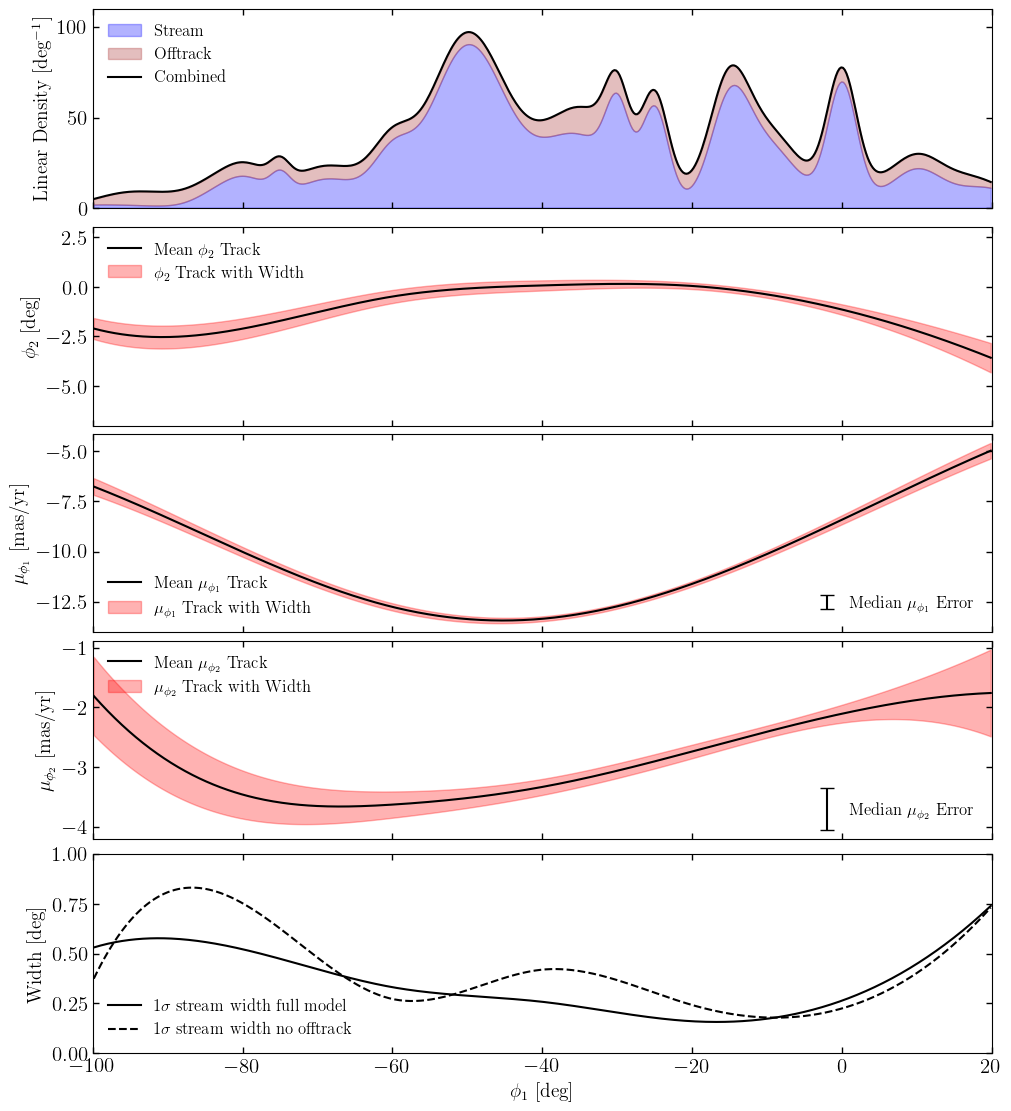

In [23]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'Stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='brown', alpha=0.3, label=r'Offtrack')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'Combined')
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,110)
ax1.legend(fontsize=12, loc='upper left')

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'Mean $\phi_2$ Track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\phi_2$ Track with Width')
# ax2.fill_between(phi1s, phi2_track_no_off(phi1s) - phi2_width_no_off(phi1s), 
#                  phi2_track_no_off(phi1s) + phi2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ Track with Width')
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, pm1_track(phi1s), c='k', label=r'Mean $\mu_{\phi_1}$ Track')
ax3.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax3.text(1, -12.8, r'Median $\mu_{\phi_1}$ Error', fontsize=12)
ax3.fill_between(phi1s, pm1_track(phi1s) - pm1_width(phi1s), pm1_track(phi1s) + pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
# ax4.fill_between(phi1s, pm1_track_no_off(phi1s) - pm1_width_no_off(phi1s), 
#                  pm1_track_no_off(phi1s) + pm1_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
ax3.set_ylabel(r'$\mu_{\phi_1}$ [mas/yr]', fontsize=14)
ax3.legend(fontsize=12, loc='lower left')

ax4.plot(phi1s, pm2_track(phi1s), c='k', label=r'Mean $\mu_{\phi_2}$ Track')
ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax4.fill_between(phi1s, pm2_track(phi1s) - pm2_width(phi1s), pm2_track(phi1s) + pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
# ax5.fill_between(phi1s, pm2_track_no_off(phi1s) - pm2_width_no_off(phi1s), 
#                  pm2_track_no_off(phi1s) + pm2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
ax4.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left')

ax5.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
ax5.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no offtrack')
ax5.set_ylim(0, 1)
ax5.set_ylabel(r'Width [deg]', fontsize=14)
ax5.legend(fontsize=12, loc='lower left')

ax5.set_xlim(-100, 20)
ax5.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

# plt.savefig('../../paper_figures/stream_properties.png')
# plt.savefig('../../paper_figures/stream_properties.pdf')
plt.show()

In [24]:
all_data_ = iso_obj.cat[pm_mask]
all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}
all_data_err = {'phi1': 1e-4, 'phi2': 1e-4,
                'pm1': jnp.array(all_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(all_data_['pm2_error'], dtype="f8")}

In [25]:
## membership probability calculation

lp_dict = {} # create dictionary of log probabilities for each component

for n_comp, component in enumerate(mm.components):
    print(component.name) #background, stream, or offtrack

    ## Get distributions for every coordinate in the component
    dists = component.make_dists(MAP_p_expanded[component.name])

    ## Create empty array of log probabilities for each data point and coordinate
    component_lp_stack = jnp.empty((len(dists), len(all_data_)))

    for i, (coord_name, dist_) in enumerate(dists.items()):
        if isinstance(coord_name, tuple): # (phi1, phi2) offtrack
            _data = jnp.stack([all_data[k] for k in coord_name], axis=-1)
            _errors = jnp.stack([all_data_err[k] for k in coord_name], axis=-1)   # Include errors
        else:
            _data = jnp.asarray(all_data[coord_name])
            _errors = jnp.asarray(all_data_err[coord_name])  # Include errors
        
        if isinstance(dist_, (IndependentGMM, dist.Uniform)):
            # IndependentGMM is only used for position space at the moment so ignoring errors is fine
            variable_lp  = dist_.log_prob(value=_data)
            
        elif isinstance(dist_, TruncatedNormalSpline): # One truncated spline
            # Get the spline mean and scale at every data point's phi1
            #  the scale should the the rms of the model scale and the error on that point
            spline_mean = dist_._loc_spl(all_data['phi1'])
            adjusted_spline_scale = jnp.sqrt(dist_._scale_spl(all_data['phi1'])**2 + _errors**2)

            # Get lower and upper bounds of truncated normal (in terms of number of stds from mean)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale
            
            # Create a truncated normal per data point
            variable_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data, 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )
        elif isinstance(dist_, TruncatedNormal1DSplineMixture): # mixture of truncated splines
            # Similar to above
            #  Create the mean and scale at each data point's 'phi1' for each of the truncated splines (shape (K, len(data)))
            spline_mean = jnp.stack([dist_._component_distributions[i]._loc_spl(all_data['phi1']) for i in range(dist_._n_components)])
            spline_scale = jnp.stack([dist_._component_distributions[i]._scale_spl(all_data['phi1']) for i in range(dist_._n_components)])
            adjusted_spline_scale = jnp.sqrt(spline_scale**2 + _errors**2)
            lower = (dist_.low - spline_mean) / adjusted_spline_scale
            higher = (dist_.high - spline_mean) / adjusted_spline_scale

            component_lp = jax.scipy.stats.truncnorm.logpdf(
                                x=_data[None, :], 
                                loc=spline_mean, 
                                scale=adjusted_spline_scale,
                                a=lower,
                                b=higher
                            )
            
            # Including the weights (is this right?)
            mixture_weights = MAP_p_expanded[component.name][coord_name]['mixing_distribution']
            weighted_comp_lp = component_lp + jnp.log(mixture_weights)[:, None]

            variable_lp = jax.scipy.special.logsumexp(weighted_comp_lp, axis=0)
            
        else: # shouldn't be used but is here just in case
            variable_lp = dist_.log_prob(value=_data, x=jnp.asarray(all_data['phi1']))

        # add log prob from this coordinate to the array for this component log prob
        component_lp_stack = component_lp_stack.at[i].set(variable_lp)

    # Get total log probability for this component and put into original dictionary
    comp_lp = jnp.sum(component_lp_stack, axis=0) + jnp.log(MAP_p_expanded['mixture-probs'][n_comp])
    lp_dict[component.name] = comp_lp
    
    print(comp_lp, jnp.max(comp_lp)) 

background
[-10.7991033  -10.25912898 -12.23838878 ... -11.62186182 -13.04424588
 -12.00983383] -7.035809058872332
stream
[-339.43173559 -284.59344638  -92.36527348 ... -219.64683661  -76.90373297
 -148.89884893] -5.074867886213188
offtrack
[-83.35443283 -70.06274141 -20.49470951 ... -62.86887359 -22.14994299
 -37.12171214] -8.758728929642265


In [26]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.75).sum())
print((memb_prob > 0.9).sum())
print((memb_prob > 0.99).sum())

2867
1984
1469
521


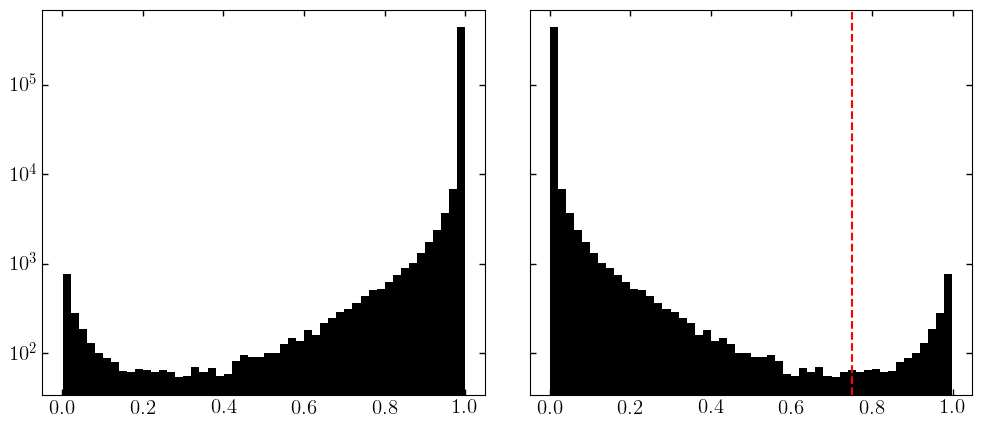

In [27]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=50)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=50)
ax2.set_yscale('log')
ax2.axvline(0.75, c='r', ls='--')

plt.show()

In [28]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.75)
memb_sel3 = np.array(memb_prob>0.9)

iso_obj.turnoff = 13.0
_ = iso_obj.simpleSln()
distmod_spl = np.poly1d([1/64**2, 100/64**2, (50/64)**2 +18.82-4.45])
dist_mod_shift = distmod_spl(all_data_["phi1"])

cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.3)
g_r = all_data_['g0'] - all_data_['r0']
Gmag = all_data['g0'] - dist_mod_shift

cmd_sel = np.array(cmd_patch.contains_points(np.array([g_r, Gmag]).T) | hb_patch.contains_points(np.array([g_r, Gmag]).T))

In [29]:
print(len(all_data_[memb_sel2]))
print(len(all_data_[memb_sel2&cmd_sel]))

1984
1521


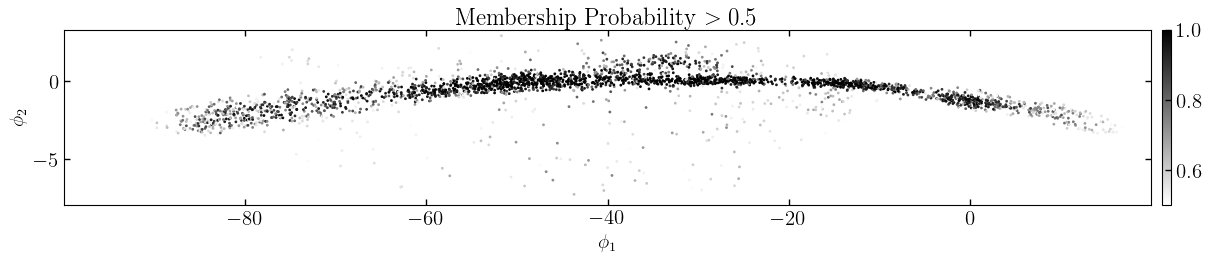

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

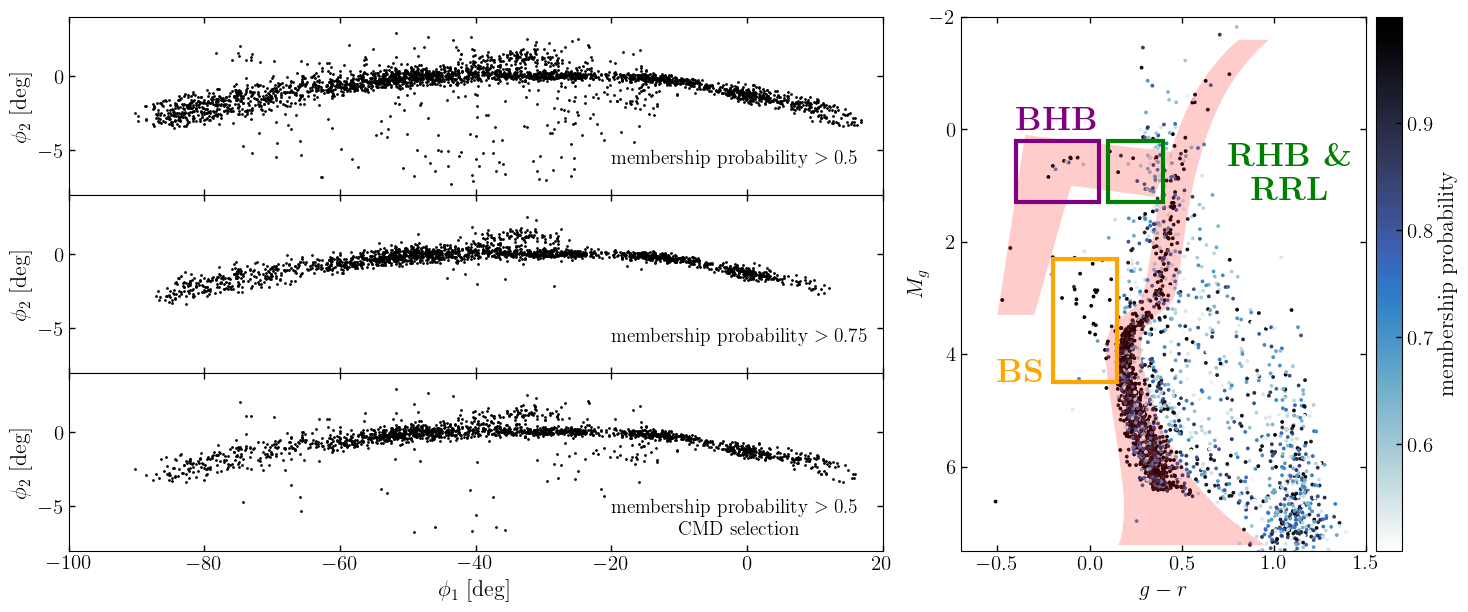

In [34]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(all_data_[memb_sel1]["phi1"]) - iso_obj.dist_mod

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,6))
gs = GridSpec(6, 2, figure=fig, width_ratios=[1, 0.6], left=0.05, right=0.97, bottom=0.09, top=0.98, wspace=0.12)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0], sharey=ax1)
ax3 = fig.add_subplot(gs[4:6, 0], sharey=ax1)
ax4 = fig.add_subplot(gs[:, 1])

ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=1)
ax1.text(-20,-6, 'membership probability $> 0.5$', fontsize=14)
# ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xticklabels([])
ax1.set_xlim(-100, 20)

ax2.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], s=1)
ax2.text(-20,-6, 'membership probability $> 0.75$', fontsize=14)
ax2.set_xticklabels([])
ax2.set_xlim(-100, 20)


# ax3.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=0.5, c='k', alpha=0.3)
ax3.scatter(all_data_[memb_sel1&cmd_sel]['phi1'], all_data_[memb_sel1&cmd_sel]['phi2'], s=1, c='k')
ax3.text(-20,-5.5, r'membership probability $> 0.5$', fontsize=14)
ax3.text(-10,-7, 'CMD selection', fontsize=14, color='k')
ax3.set_xlim(-100, 20)
ax3.set_ylim(-8,4)

im = ax4.scatter(all_data_[memb_sel1]['g0'] - all_data_[memb_sel1]['r0'], 
            all_data_[memb_sel1]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod,
            c = memb_prob[memb_sel1],
            cmap=cmr.arctic_r, s=3)
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)
rrl_patch = mpl.patches.Polygon(jnp.array([[0.1,1.3], [0.1,0.2], [0.4,0.2], [0.4,1.3]]), edgecolor="green", facecolor='none', lw=3)
bhb_patch = mpl.patches.Polygon(jnp.array([[-0.4,1.3], [-0.4,0.2], [0.05,0.2], [0.05,1.3]]), edgecolor="purple", facecolor='none', lw=3)
bs_patch = mpl.patches.Polygon(jnp.array([[-0.2,4.5], [-0.2,2.3], [0.15,2.3], [0.15,4.5]]), edgecolor="orange", facecolor='none', lw=3)
ax4.add_patch(cmd_patch) ; ax4.add_patch(hb_patch)
ax4.add_patch(rrl_patch) ; ax4.add_patch(bhb_patch) ; ax4.add_patch(bs_patch)
ax4.text(0.75,1.25,r'\textbf{RHB \&}' + '\n' + r'\textbf{RRL}', color='green', fontsize=24, ma='center')
ax4.text(-0.4,0,r'\textbf{BHB}', color='purple', fontsize=24)
ax4.text(-0.5,4.5,r'\textbf{BS}', color='orange', fontsize=24)
ax4.set_xlabel(r'$g-r$', fontsize=16)
ax4.set_ylabel(r'$M_g$', fontsize=16, labelpad=0)
ax4.set_xlim(-0.7, 1.5)
ax4.set_ylim(7.5, -2)
cbar = fig.colorbar(im, ax=ax4, pad=0.02)
cbar.set_label('membership probability', fontsize=16)

ax1.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
plt.subplots_adjust(hspace=0, wspace=0.15)
# plt.savefig('../../paper_figures/high_prob_members.pdf')
# plt.savefig('../../paper_figures/high_prob_members.png')
plt.show()

In [56]:
all_data_['pass_CMD_cut'] = cmd_sel
all_data_['memb_prob'] = memb_prob
all_data_

<Table length=466571>
     source_id              ra         ... pass_CMD_cut       memb_prob       
                                       ...                                    
       int64             float64       ...     bool            float64        
------------------- ------------------ ... ------------ ----------------------
 576748068435698048 134.13841688083966 ...         True 2.9636494291125534e-71
 576748244530543488 134.16732705372561 ...        False 4.3353120232019063e-61
 576750301818727936 134.22981963824748 ...        False  3.319592181041034e-09
 576760064280542592 134.14547166643905 ...        False 1.6266252485639846e-50
 576760300502579328  134.1113034294974 ...         True 1.4771765163693314e-64
 576760334862325504 134.12016082647645 ...        False  2.742248780625406e-25
 576760437941539712  134.1564021078413 ...        False  3.110442084323623e-16
 576760884618149248 134.16590122401283 ...        False 4.3952548310362264e-33
 576761262575264896 134.04034521551716 ...        False 3.9341394092192606e-92
                ...                ... ...          ...                    ...
5763858171501338752 132.35958296457127 ...        False  9.684196134022174e-10
5763858416314087936  132.4222150913482 ...         True  3.967340266142068e-49
5763859442811671936  132.3831513160118 ...        False 1.2175883937203773e-07
5763864734211393664 132.43933225841755 ...        False 2.9979997330042293e-78
5763865460060452224 132.39955636942776 ...        False  5.545651890341199e-30
5763865734938359552 132.38369519625394 ...        False 3.8161744909666585e-14
5763865902442504064  132.4447438143082 ...        False 3.8399090709268015e-57
5763866246039894400 132.41030567238795 ...        False  2.829741323029883e-16
5763868582502122624 132.53086892838647 ...        False  1.174881141668414e-30

Add labels to the right plot for BHB, EBHB, BS (see plot from Adrian KITP talk for example)

Make choice for knots based on vibes and say that other choices give virtually identical membership probabilities. Other option is to get the log-likelihood from numpyro somehow

### Create the distance-corrected CMD

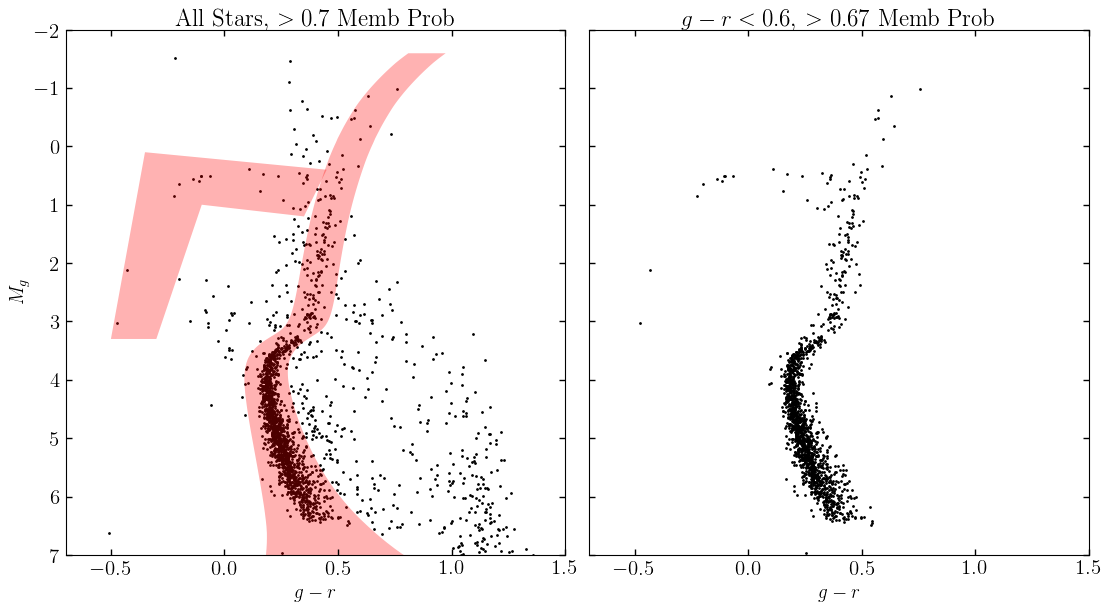

In [26]:
dist_mod_correct = distmod_spl(all_data_[memb_sel2]["phi1"])
dist_mod_correct_cmd_cut = distmod_spl(all_data_[memb_sel2&cmd_sel]["phi1"])

cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.3)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel2]['g0'] - all_data_[memb_sel2]['r0'], 
            all_data_[memb_sel2]['g0'] - dist_mod_correct, 
            c='k', s=1)
ax1.add_patch(cmd_patch)
ax1.add_patch(hb_patch)
ax1.set_title(r'All Stars, $>0.7$ Memb Prob')

ax1.set_xlabel(r'$g-r$', fontsize=14)
ax1.set_ylabel(r'$M_g$', fontsize=14)

ax1.set_xlim(-0.7, 1.5)
ax1.set_ylim(7, -2)

ax2.scatter(all_data_[memb_sel2&cmd_sel]['g0'] - all_data_[memb_sel2&cmd_sel]['r0'], 
            all_data_[memb_sel2&cmd_sel]['g0'] - dist_mod_correct_cmd_cut, 
            c='k', s=1)
ax2.set_title(r'$g-r<0.6$, $>0.67$ Memb Prob')

ax2.set_xlabel(r'$g-r$', fontsize=14)

ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(7, -2)
plt.show()

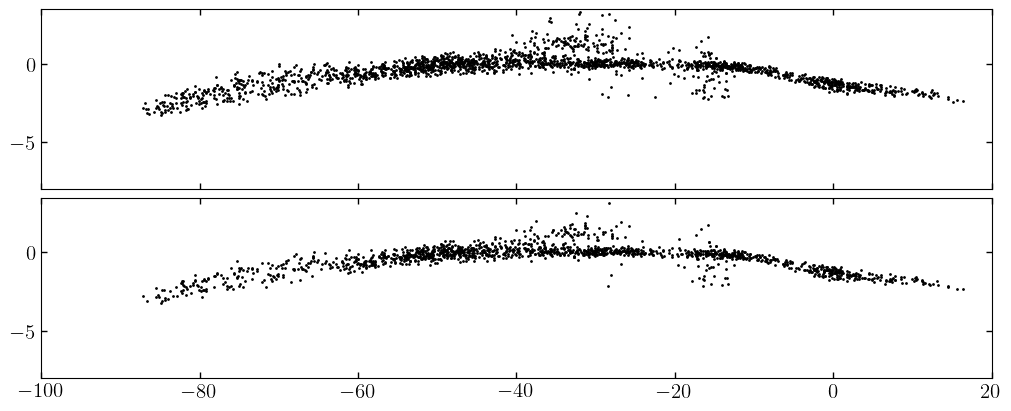

In [30]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], s=1)

ax2.scatter(all_data_[memb_sel2&cmd_sel]['phi1'], all_data_[memb_sel2&cmd_sel]['phi2'], s=1)
ax2.set_xlim(-100, 20)
ax2.set_ylim(-8,3.5)
plt.show()

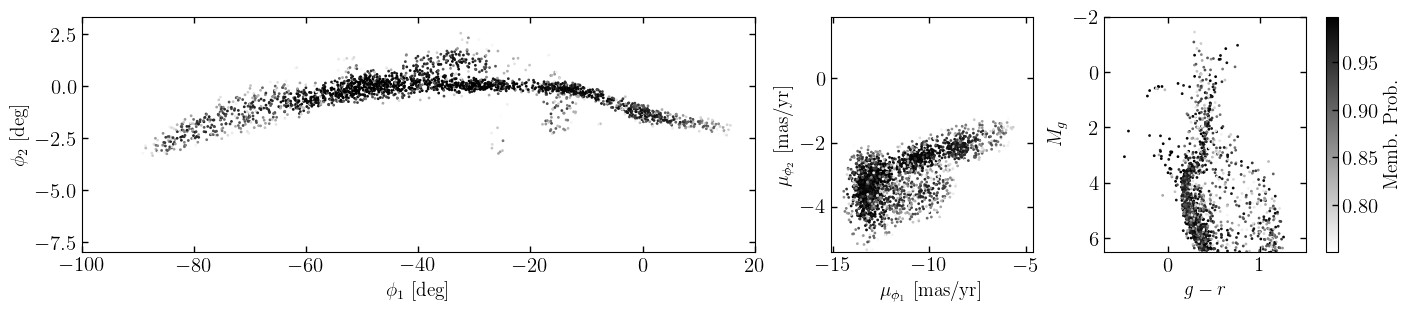

In [94]:
c_map='gray_r'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14,3), layout="constrained")
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 0.30, 0.30])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0,2])

im1 = ax1.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], c=memb_prob[memb_sel2],
            s=1, cmap=c_map)
ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax1.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax1.set_xlim(-100, 20)
ax1.set_ylim(coord_bounds['phi2'])

im2 = ax2.scatter(all_data_[memb_sel2]['pm1'], all_data_[memb_sel2]['pm2'], c=memb_prob[memb_sel2],
            s=1, cmap=c_map)
ax2.set_xlabel(r"$\mu_{\phi_1}$ [mas/yr]", fontsize=14)
ax2.set_ylabel(r"$\mu_{\phi_2}$ [mas/yr]", fontsize=14)
ax2.set_xlim(coord_bounds['pm1'])
ax2.set_ylim(coord_bounds['pm2'])


im3 = ax3.scatter(all_data_[memb_sel2]['g0'] - all_data_[memb_sel2]['r0'], 
                  all_data_[memb_sel2]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
                  c=memb_prob[memb_sel2], s=1, cmap=c_map)
# ax3.add_patch(cmd_patch)
# ax3.set_title(r'All Stars $>0.75$ Memb Prob')

ax3.set_xlabel(r'$g-r$', fontsize=14)
ax3.set_ylabel(r'$M_g$', fontsize=14)

ax3.set_xlim(-0.7, 1.5)
ax3.set_ylim(6.5, -2)

cbar = fig.colorbar(im3, ax=ax3, pad=0.1)
cbar.set_label('Memb. Prob.', fontsize=14)
# plt.savefig('../../paper_figures/high_prob_members.pdf')
plt.show()

In [57]:
all_data_.write('../../data/gd1_tbl_with_memb_prob.fits', overwrite=True)

#### Check blob and spur proper motions

In [121]:
old_tbl_ = at.Table.read('../../data/gd1_tbl_with_memb_prob.fits')
old_tbl = old_tbl_[(old_tbl_['memb_prob'] > 0.5) & old_tbl_['pass_CMD_cut']]

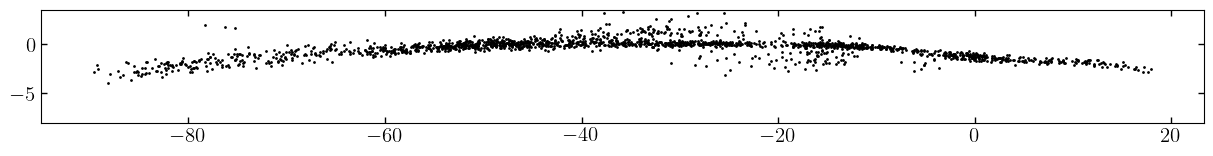

In [129]:
fig, ax = plt.subplots(1,1, figsize=(15, 3))
ax.scatter(old_tbl['phi1'], old_tbl['phi2'], s=1)
ax.set_ylim(-8, 3.5)
ax.set_aspect('equal')

In [157]:
blob_region = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-13)]
blob = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-10) & (old_tbl['phi2']<-0.35)]

spur_region = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-25)]
spur = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-25) & (old_tbl['phi2']>0.5)]

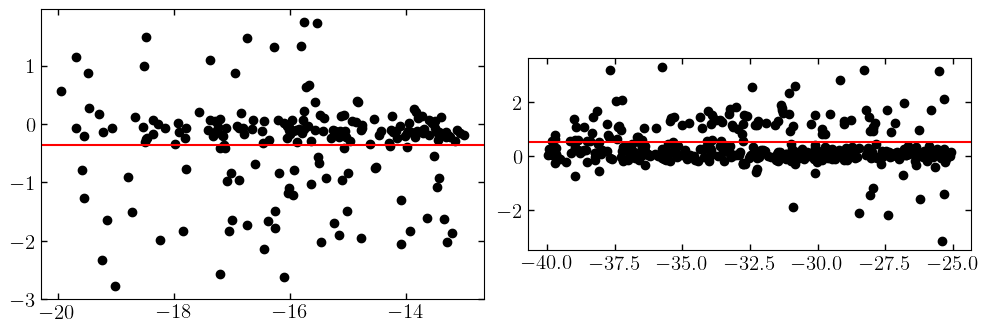

In [158]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))
ax1.scatter(blob_region['phi1'], blob_region['phi2'], c='k')
ax1.axhline(-0.35, color='r')
ax1.set_aspect('equal')

ax2.scatter(spur_region['phi1'], spur_region['phi2'], c='k')
ax2.axhline(0.5, color='r')
ax2.set_aspect('equal')
plt.show()

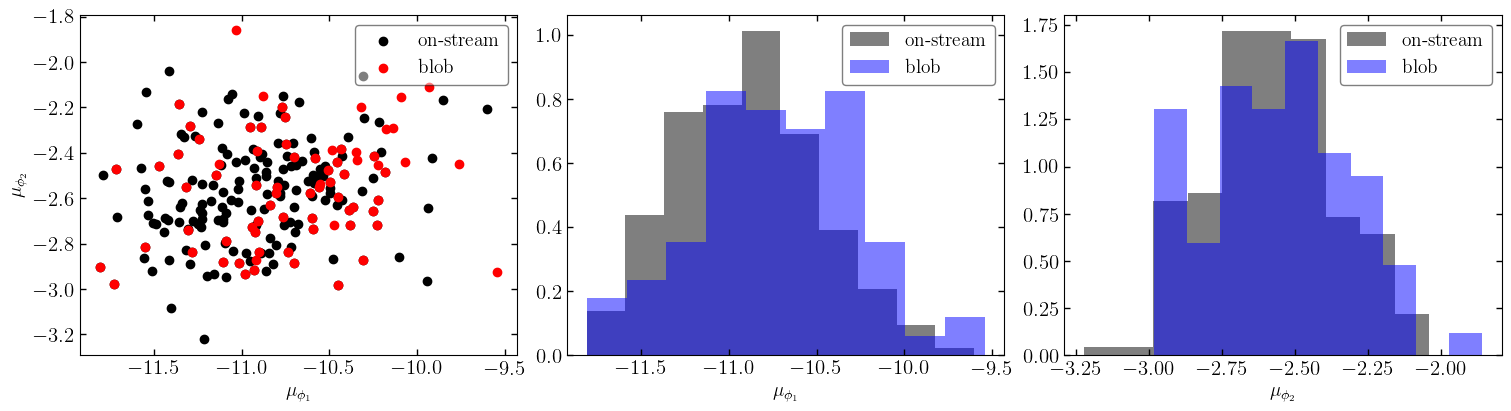

In [179]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(blob_region['pm1'], blob_region['pm2'], c='k', label='on-stream')
ax1.scatter(blob['pm1'], blob['pm2'], c='r', label='blob')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k')

ax2.hist(blob_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(blob['pm1'], density=True, alpha=0.5, label='blob')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(blob_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(blob['pm2'], density=True, alpha=0.5, label='blob')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

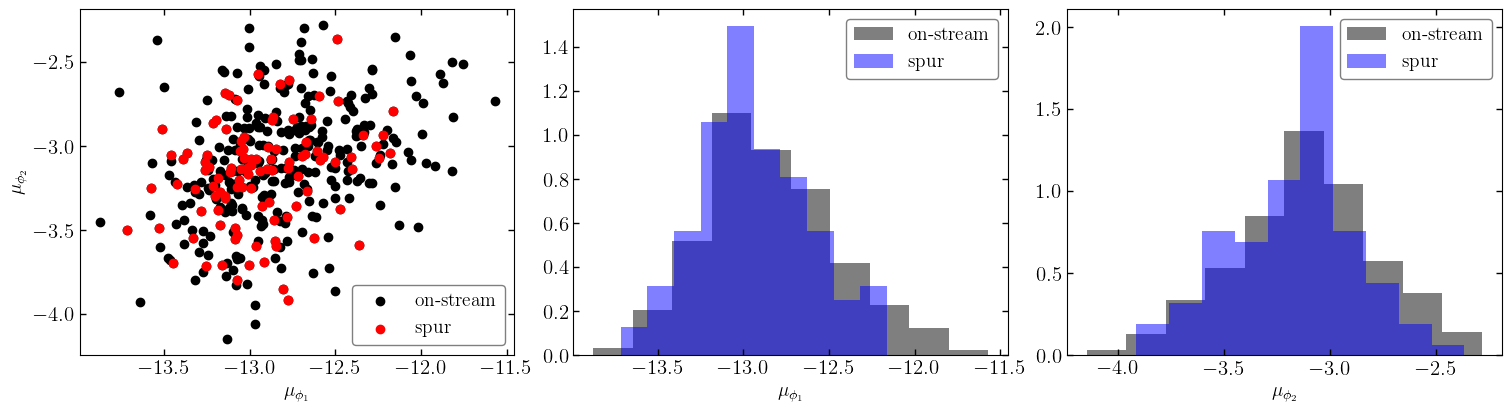

In [182]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(spur_region['pm1'], spur_region['pm2'], c='k', label='on-stream')
ax1.scatter(spur['pm1'], spur['pm2'], c='r', label='spur')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k', loc='lower right')

ax2.hist(spur_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(spur['pm1'], density=True, alpha=0.5, label='spur')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(spur_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(spur['pm2'], density=True, alpha=0.5, label='spur')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

## Make Paper Plots

### Background Model

In [74]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
bkg_filename = svi_results_dir + 'bkg_{}_{}_{}.pkl'.format(*bkg_knot_spacings)

with open(bkg_filename, 'rb') as input_file_:
    bkg_dict = pickle.load(input_file_)
    
bkg_svi_results = bkg_dict['svi_results']
bkg_guide = bkg_dict['guide']

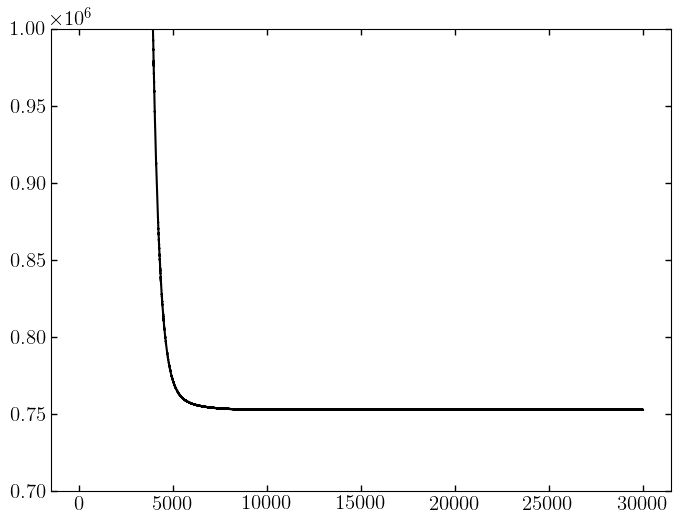

In [77]:
plt.plot(bkg_svi_results.losses)
plt.ylim(7e5, 1e6)
plt.show()

bkg_params = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                            guide=bkg_guide, num_samples=10_000, key=jax.random.PRNGKey(12345))

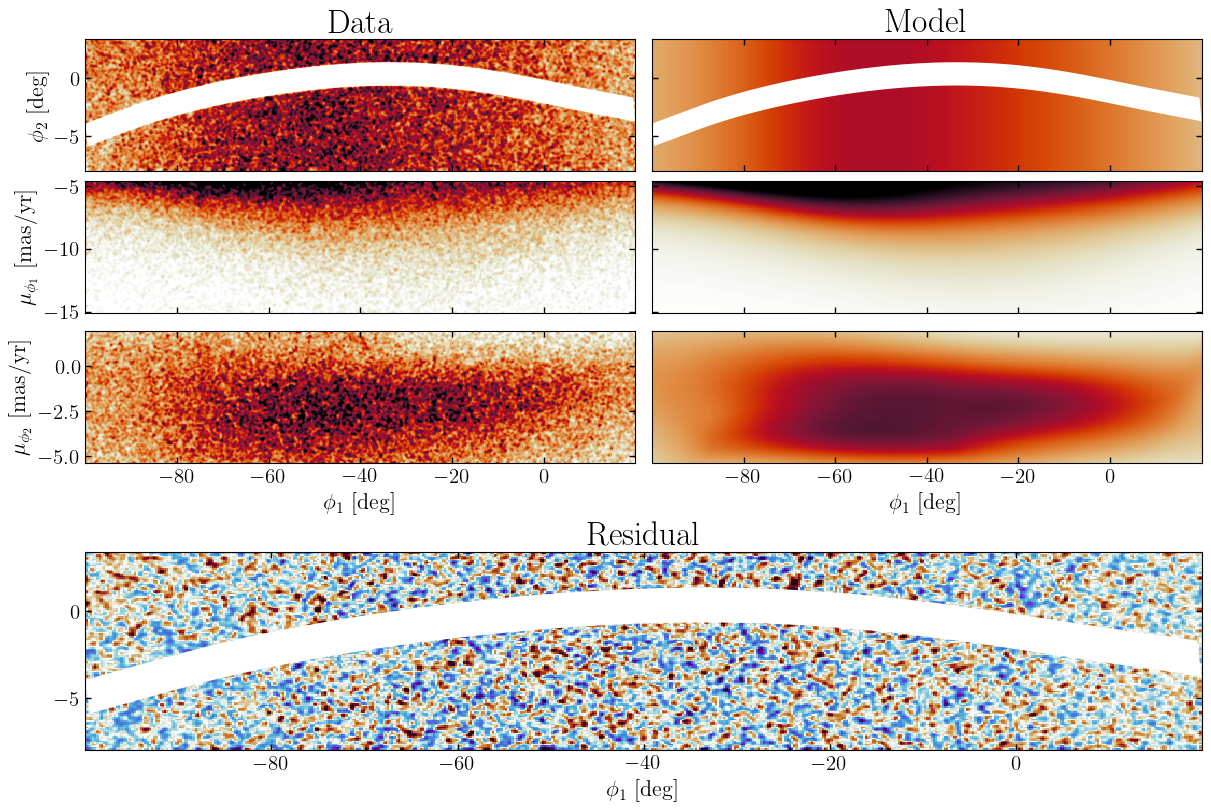

In [83]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)

ax7 = fig.add_subplot(gs[3, :], sharex=ax1)

plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[ax1,ax3,ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[ax1,ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

bkg_model.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'pm1')],
                                 pars=bkg_params, axes=ax4, label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                                 pars=bkg_params, axes=[ax2,ax6], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

bkg_model.plot_residual_projections(
    grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], 
    pars=bkg_params,
    data=run_data, axes=ax7, label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap=cmr.fusion, rasterized=True)
)

blank = cmr.take_cmap_colors(cmap, N=2, return_fmt='hex')[0]
for ax in [ax1,ax2,ax7]:
    patch_sky = mpl.patches.Polygon(
            iso_obj.pawprint.skyprint["stream"].vertices[::50],
            facecolor=blank,
            alpha=1
        )
    ax.add_patch(patch_sky)

for ax in [ax1, ax2, ax3, ax4]:
    ax.label_outer()
ax6.yaxis.set_visible(False)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax7.set_title('Residual', fontsize=24, pad=5)

plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

### Stream Model

In [79]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
stream_filename = svi_results_dir + 'stream_{}_{}_{}_{}.pkl'.format(*stream_knot_spacings)

with open(stream_filename, 'rb') as input_file_:
    stream_dict = pickle.load(input_file_)
    
stream_svi_results = stream_dict['svi_results']
stream_guide = stream_dict['guide']

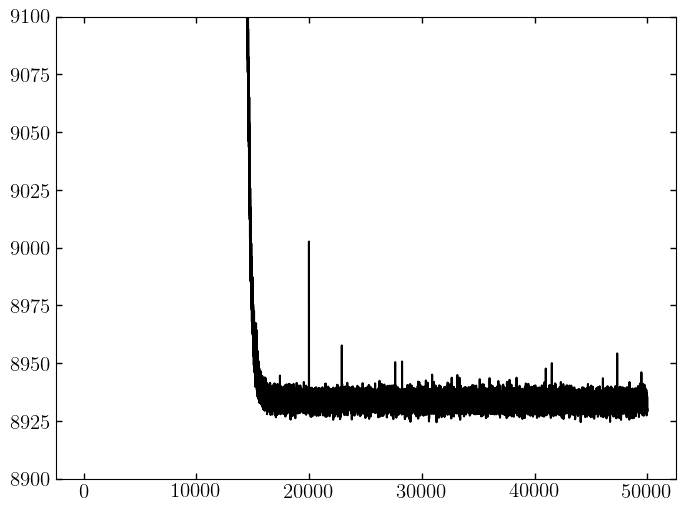

In [80]:
plt.plot(stream_svi_results.losses)
plt.ylim(8900, 9100)
plt.show()

stream_params = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                            guide=stream_guide, num_samples=10_000, key=jax.random.PRNGKey(12345))

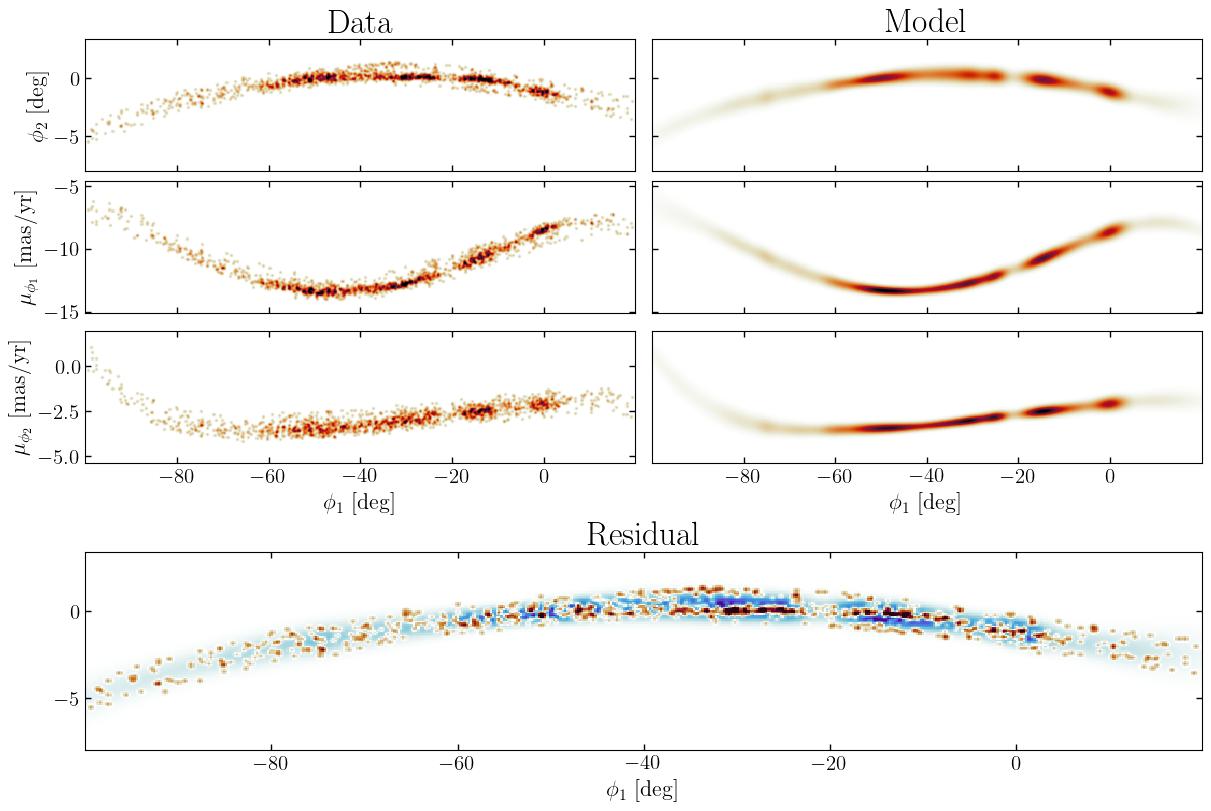

In [82]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)

ax7 = fig.add_subplot(gs[3, :], sharex=ax1)

plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=[ax1,ax3,ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap)
)

stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, pars=stream_params, axes=[ax2,ax4,ax6], label=False,
                                 pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
# bkg_model.plot_model_projections(data=bkg_data, grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
#                                  pars=bkg_params, axes=[axes[0, 1], axes[2,1]], label=False,
#                                  pcolormesh_kwargs=dict(rasterized=True, vmax=2.5, vmin=0, cmap=cmap))

stream_model.plot_residual_projections(
    grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], pars=stream_params,
    data=stream_data, axes=ax7, label=False, 
    pcolormesh_kwargs=dict(vmin=-0.5, vmax=0.5, cmap=cmr.fusion, rasterized=True)
)

for ax in [ax1, ax2, ax3, ax4]:
    ax.label_outer()
ax6.yaxis.set_visible(False)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax7.set_title('Residual', fontsize=24, pad=5)

plt.savefig('../../paper_figures/stream_model.pdf')
plt.show()

In [185]:
stream_model.coord_parameters['pm1']

{'loc_vals': <numpyro.distributions.continuous.Normal at 0x37cc0fb00>,
 'scale_vals': <numpyro.distributions.distribution.ExpandedDistribution at 0x36ae11ee0>,
 'knots': Array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.], dtype=float64),
 'x': Array([-76.22364036, -75.99018794, -75.83424675, ..., -92.18953976,
        -92.12586199, -91.36207345], dtype=float64),
 'low': Array(-15.09995579, dtype=float64),
 'high': Array(-4.63627283, dtype=float64),
 'spline_k': 3,
 'clip_locs': (Array(-15.09995579, dtype=float64),
  Array(-4.63627283, dtype=float64)),
 'clip_scales': (0.1, None)}

## Random check on the side

In [204]:
new_plot_grids = {}
for key, val in plot_grids.items():
    new_plot_grids[key] = val[::2]

In [249]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

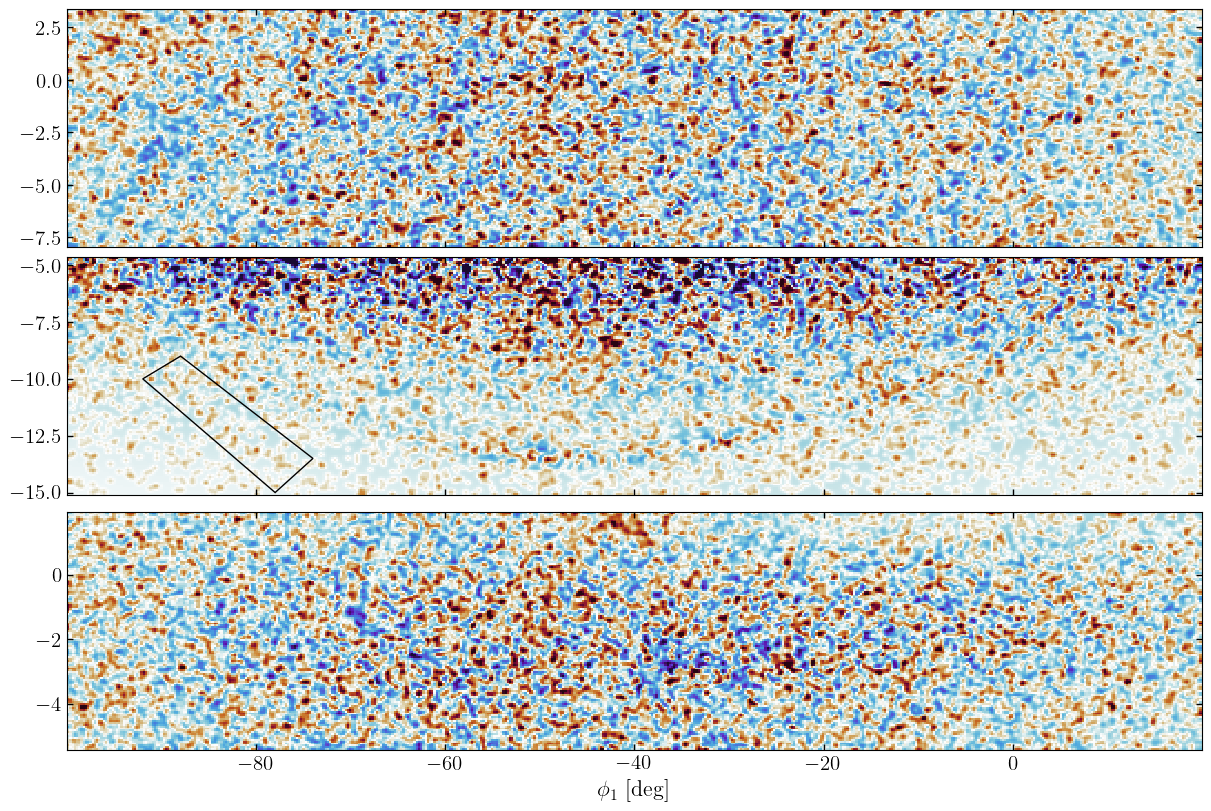

In [250]:
fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True, constrained_layout=True)
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=axs, label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion)
)
axs[1].add_patch(pm1_patch)
plt.show()

In [251]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

In [252]:
sel = pm1_patch.contains_points(jnp.array([run_data_['phi1'], run_data_['pm1']]).T)

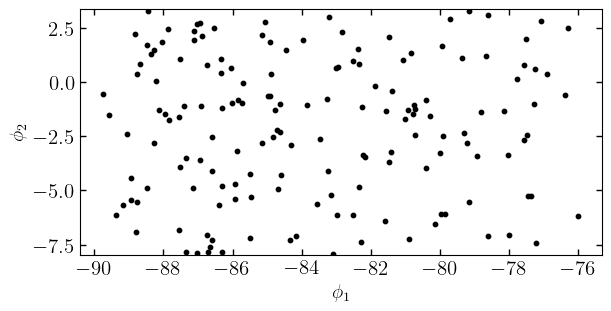

In [253]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['phi2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
plt.show()

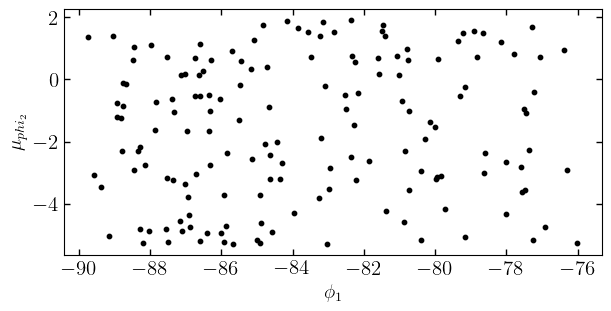

In [254]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['pm2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\mu_{phi_2}$')
plt.show()